In [1]:
%cd ../src/

/mnt/c/Users/Jacob/Desktop/prosjektoppgave/tcav_atari/src


In [2]:
import time

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator

from concepts import concept_instances
from sk_probing import train_binary, train_non_binary
from utils import load_game_data, prepare_folders

In [3]:
prepare_folders('../figures/input_availability/')

In [4]:
max_data_size = 1000
max_iter = 200
k_fold = 5
num_reg = 5

In [5]:
game_data = load_game_data()

ball y score: 0.1356254735109529


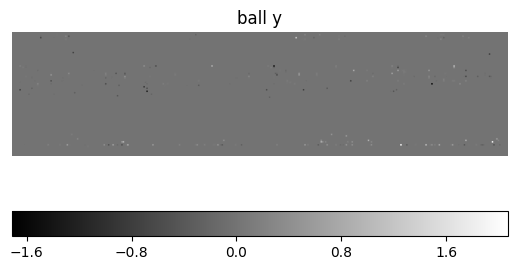

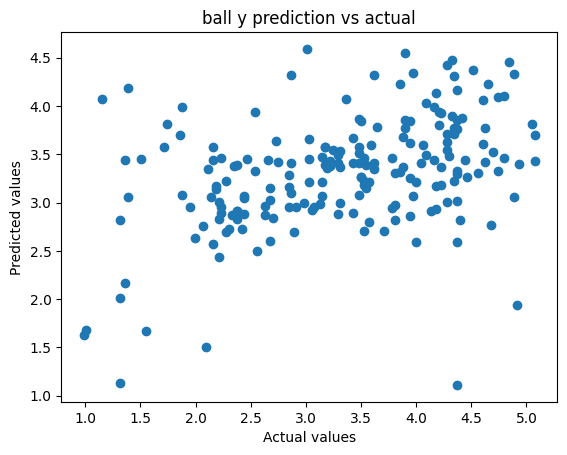

Time elapsed: 9.17 seconds
ball x score: 0.35541048961618216


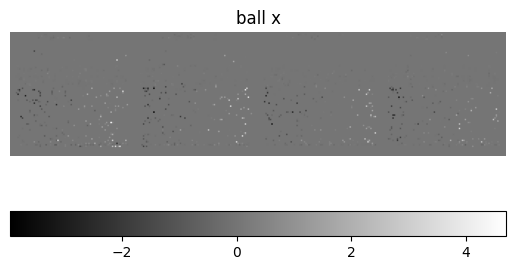

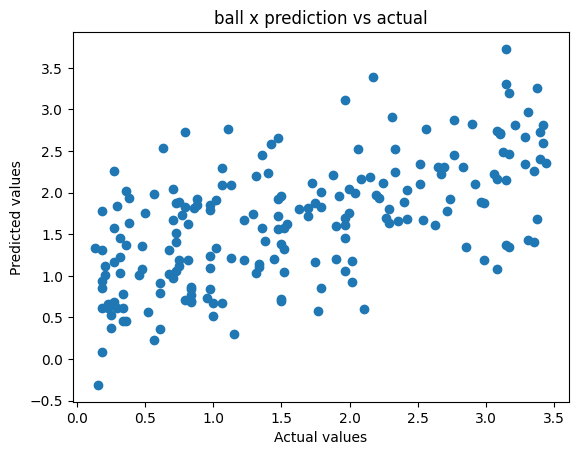

Time elapsed: 9.62 seconds
ball low (b) score: 0.5900000000000001


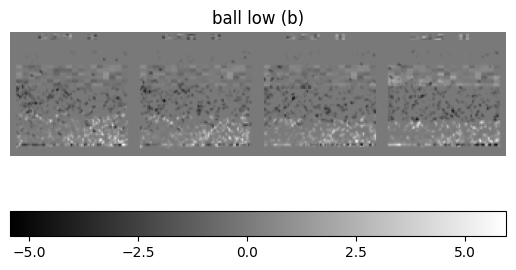

Time elapsed: 21.01 seconds
ball collision (b) score: 0.3899999999999999


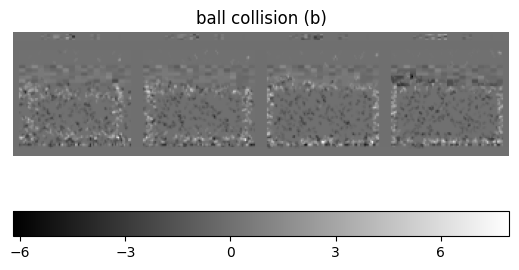

Time elapsed: 20.45 seconds
ball going right (b) score: 0.18999999999999995


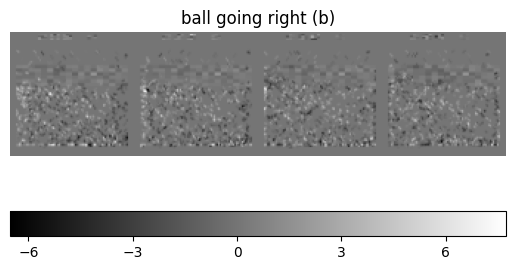

Time elapsed: 20.08 seconds
ball going left (b) score: 0.18999999999999995


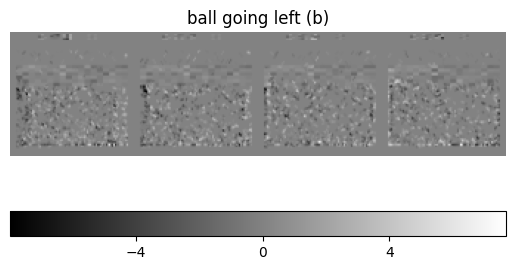

Time elapsed: 20.28 seconds
ball going up (b) score: 0.26


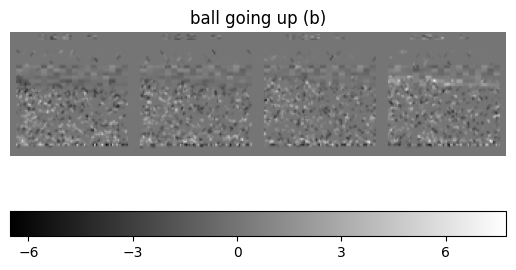

Time elapsed: 20.63 seconds
ball going down (b) score: 0.17999999999999994


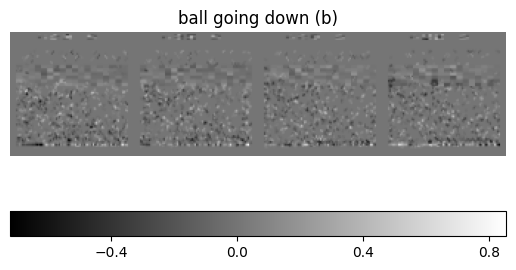

Time elapsed: 21.23 seconds
ball speed score: 0.3016500031125223


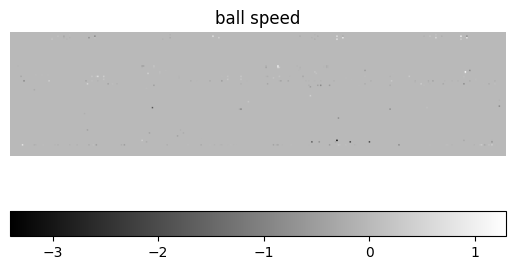

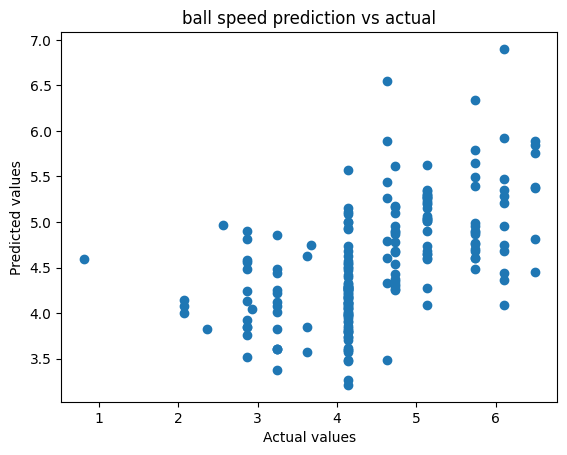

Time elapsed: 9.55 seconds
paddle x score: 0.9847126119776551


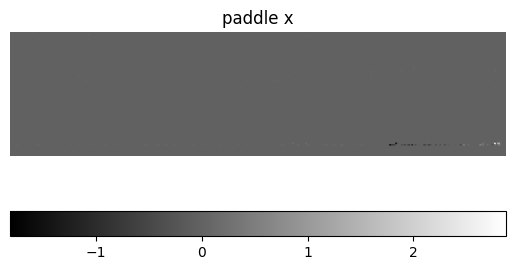

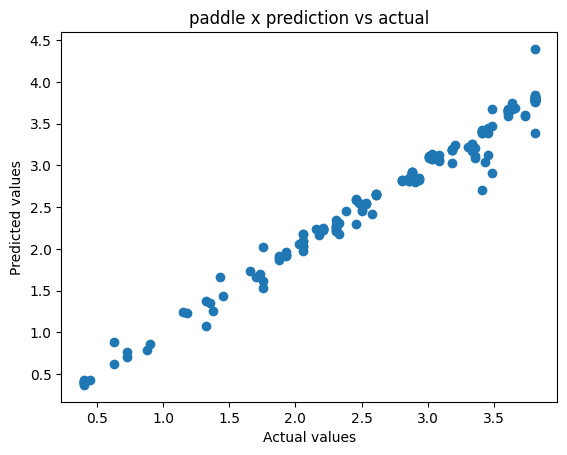

Time elapsed: 8.94 seconds
ball left for paddle (b) score: 0.43999999999999995


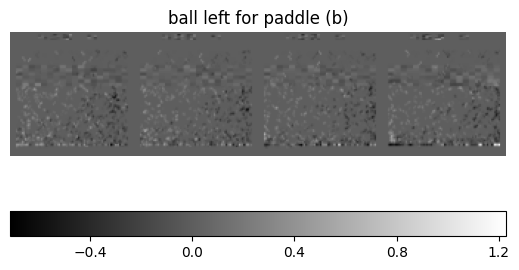

Time elapsed: 20.75 seconds
ball right for paddle (b) score: 0.3999999999999999


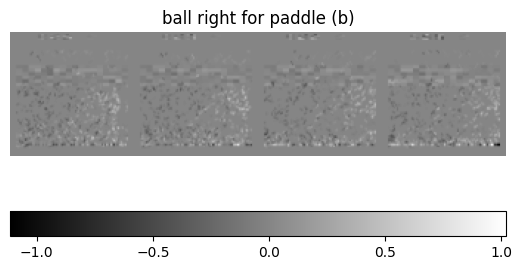

Time elapsed: 19.63 seconds
ball above paddle (b) score: 0.3600000000000001


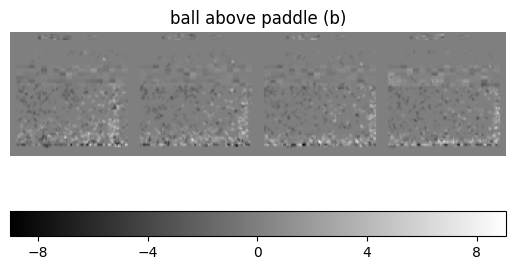

Time elapsed: 18.30 seconds
ball paddle distance score: 0.5222313128521403


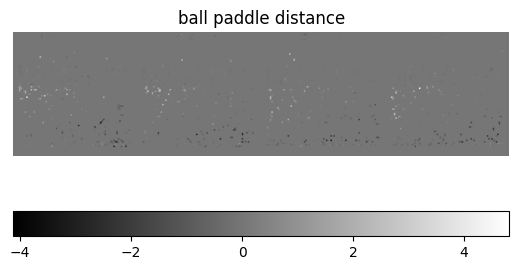

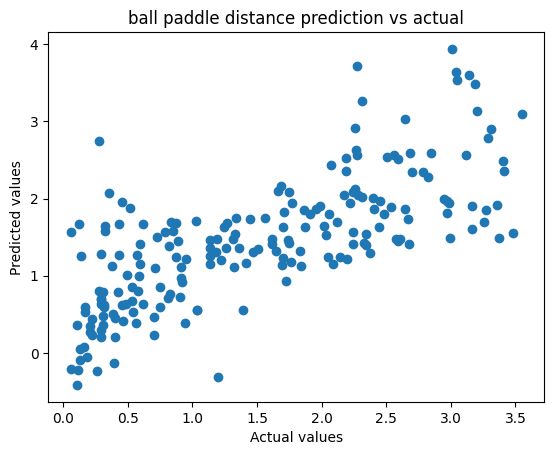

Time elapsed: 9.06 seconds
lives score: 0.9999932766827492


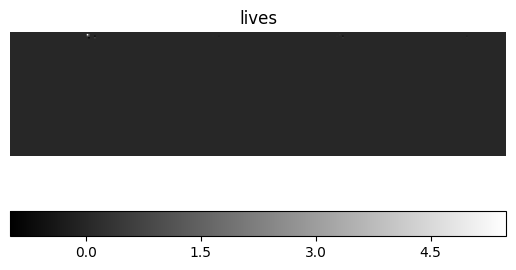

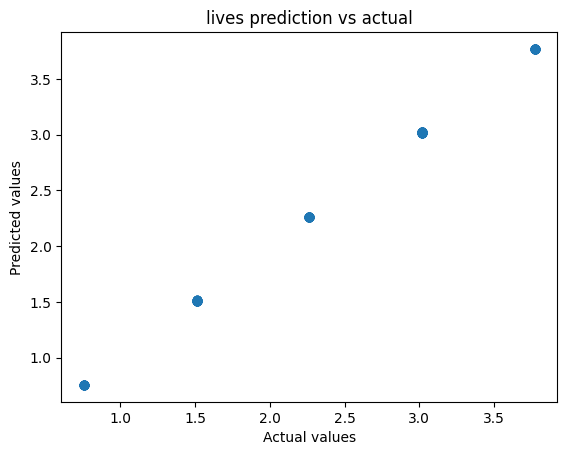

Time elapsed: 7.30 seconds
last life (b) score: 1.0


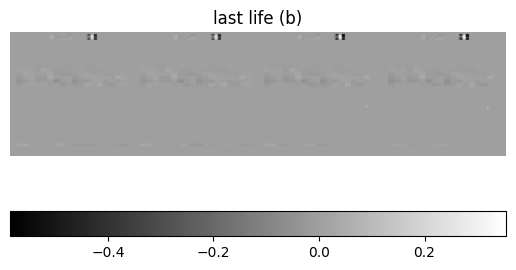

Time elapsed: 8.95 seconds
losing life (b) score: 0.5714285714285714


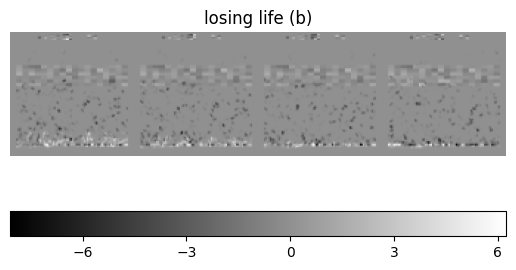

Time elapsed: 19.05 seconds
random (b) score: 0.050000000000000044


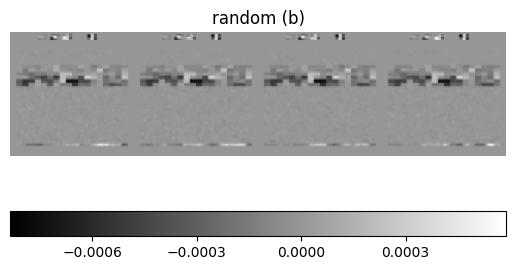

Time elapsed: 16.77 seconds
brick hit (b) score: 0.6200000000000001


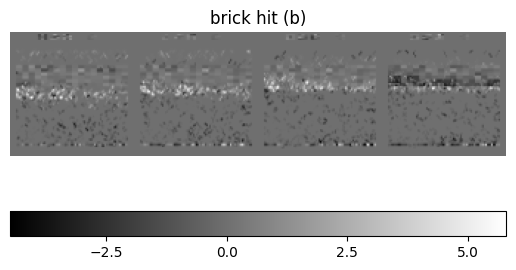

Time elapsed: 19.54 seconds
bricks hit score: 0.9989236423716323


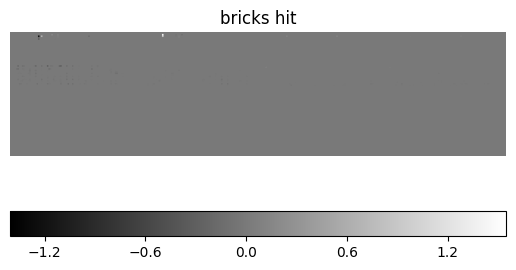

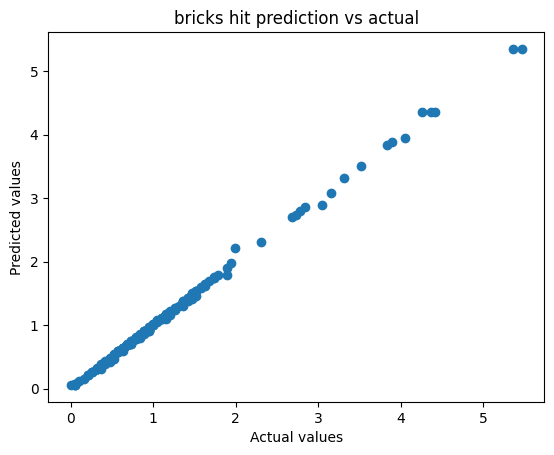

Time elapsed: 9.51 seconds


In [12]:
start = time.time()
for concept in concept_instances.values():
    concept.prepare_data(game_data, max_size=max_data_size)
    train_obs = concept.train_obs.reshape(len(concept.train_obs), -1) / 255
    test_obs = concept.test_obs.reshape(len(concept.test_obs), -1) / 255
    if concept.binary:
        reg, score = train_binary(train_obs, concept.train_values, test_obs, concept.test_values, max_iter, k_fold, num_reg)
    else:
        reg, score = train_non_binary(train_obs, concept.train_values, test_obs, concept.test_values, max_iter, k_fold, num_reg)
    print(f'{concept.name} score: {score}')

    # plot the coefficents of reg with grey scale
    coefs = np.concatenate(reg.coef_.reshape(4,84,84), axis=1)
    img = plt.imshow(coefs, cmap='gray')
    cbar = plt.colorbar(img, location='bottom')
    cbar.locator = MaxNLocator(nbins=5)
    cbar.update_ticks()
    plt.axis('off')
    plt.axis('off')
    plt.title(f'{concept.name}')
    plt.savefig(f'../figures/input_availability/{concept.name}_coeffs.png', bbox_inches='tight')
    plt.show()

    # plot preds vs. true values if non-binary
    if not concept.binary:
        plt.scatter(concept.test_values, reg.predict(test_obs))
        plt.xlabel('Actual values')
        plt.ylabel('Predicted values')
        plt.title(f'{concept.name} prediction vs actual')
        plt.show()

    print(f'Time elapsed: {time.time()-start:.2f} seconds')
    start = time.time()